<a href="https://colab.research.google.com/github/marvijokhio/awesome-nlp/blob/master/Copy_of_RealNtTwtDisasClas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup**

In [1]:
pip install \
   pandas matplotlib numpy \
   nltk seaborn sklearn gensim \
   wordcloud textblob spacy missingno \
   pyenchant contractions cleanlab

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 317kB 11.0MB/s 
     |████████████████████████████████| 245kB 12.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=898c0a3518b4f1607471bec80e3ab9e0d7bbbeca17004c029840dfb0e8c9b8da
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


Libraries which are not available in colab by default

In [2]:
!pip install pyLDAvis  # Library not in colab bydefaul
!pip install textstat  # Library not in colab bydefaul

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 18.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=8ccad204652cfdb7c07774cfd4c07a6ea3bf9e581596d0facec0ca5f2c47d1e4
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=13c8e1218f9f011fd1447acea723d98427dd18432dee5761c39ee0874f58034a
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 3.0MB 8.4MB/s 


In [3]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

from cleanlab.pruning import get_noise_indices
from cleanlab.classification import LearningWithNoisyLabels

import contractions
import seaborn as sns
import sklearn
import gensim
import pyLDAvis 
import wordcloud
import textblob 
import spacy
import textstat
import missingno as msno
import cufflinks as cf
cf.go_offline()

import warnings


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data Analysis and Preprocessing:**


1. Merging train and test set to have concrete idea of whole dataset.

In [5]:
train = pd.read_csv('data/train.csv')
#train

In [6]:
test = pd.read_csv('data/test.csv')
#test.head(10)

In [7]:
tr = pd.read_csv('data/sample_submission.csv')
tr.drop(columns=['id'], inplace=True)
#tr.head(10)

In [8]:
test['target'] = tr 
#test

In [9]:
df = pd.concat([train, test],ignore_index= True)
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,0
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,0
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,0


2. Finding Missing Values

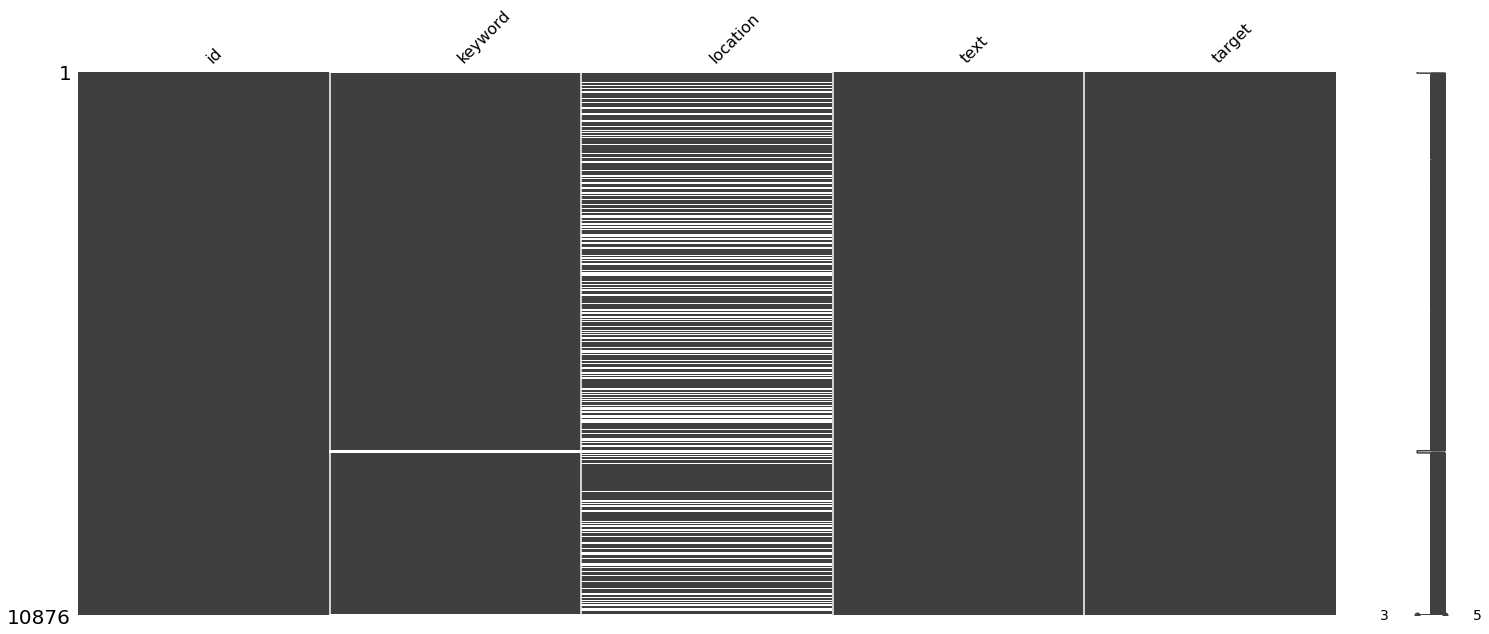

In [10]:
msno.matrix(df)
plt.show()

In [11]:
print('Total null values for each column:\n', df.isnull().sum())

Total null values for each column:
 id             0
keyword       87
location    3638
text           0
target         0
dtype: int64


In [12]:
df['keyword'].fillna('NoKeyword', inplace = True)
train['temp'] = train['keyword'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Top_Common_Keywords','count']
temp.style.background_gradient(cmap='Blues')

,Top_Common_Keywords,count
0,nan,61
1,fatalities,45
2,armageddon,42
3,deluge,42
4,body%20bags,41
5,damage,41
6,harm,41
7,sinking,41
8,collided,40
9,evacuate,40


Since, our main fields of interest are text and keywords from independent vairables. The field location is not much important here and we can drop it.  

In [13]:
df.drop(columns = ['location'], inplace = True)
train.drop(columns = ['location'], inplace = True)
test.drop(columns = ['location'], inplace = True)

# Distribution Analysis:
Let's look at the distribution of classes in train, test and merged datasets. 

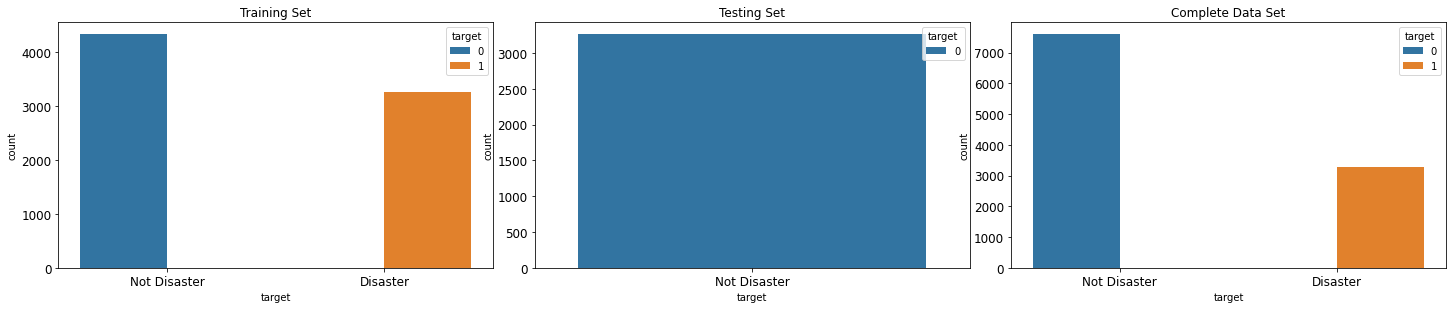

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
plt.tight_layout()

sns.countplot(x=train['target'], hue=train['target'], ax=axes[0])
sns.countplot(x=test['target'], hue=test['target'], ax=axes[1])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[2])

axes[0].set_xticklabels(['Not Disaster', 'Disaster'])
axes[1].set_xticklabels(['Not Disaster', 'Disaster'])
axes[2].set_xticklabels(['Not Disaster', 'Disaster'])

axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)

axes[0].set_title('Training Set', fontsize=12)
axes[1].set_title('Testing Set', fontsize=12)
axes[2].set_title('Complete Data Set', fontsize=12)
plt.show()

Since, the dataset seems to be overall biased to non disastrous tweets from merged dataset but all that matter is our trainset which is responsible for train our models so it is almost uniformly distributed amoungst both classes.     

In [15]:
train.drop_duplicates(subset=['text', 'target'],keep='first')

,id,keyword,text,target,temp
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,[nan]
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,[nan]
2,5,NaN,All residents asked to 'shelter in place' are ...,1,[nan]
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,[nan]
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,[nan]
...,...,...,...,...,...
7604,10863,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,[nan]
7605,10864,NaN,on the flip side I'm at Walmart and there is a...,1,[nan]
7606,10866,NaN,Suicide bomber kills 15 in Saudi security site...,1,[nan]
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,[nan]


In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    text = contractions.fix(text)
    text = str(text).lower()  #lowercase
    text = re.sub('#\w*[a-zA-Z]\w*', '',text)  #removing hashtags
    text = re.sub('(?<=\[)[^]]+(?=\])', '', text)
    text = re.sub('http\S+', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = remove_stopwords_lemm(text)
    return text

In [17]:
def remove_stopwords_lemm(txt):
  
  filtered_txt = [w for w in word_tokenize(txt) if (w not in stop)]
  
  lem=WordNetLemmatizer()
  filtered_txt = [lem.lemmatize(w) for w in filtered_txt if len(w)>2]
  separator = ' '
  return separator.join(filtered_txt)

In [18]:
def deep_clean(text): 
            
    # Special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text)
    
    # Contractions
    text = contractions.fix(text)
    text = re.sub(r"there's", "there is", text)  
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)   
            
    # Character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)
    
    # Typos, slang and informal abbreviations
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"w/", "with", text)
    text = re.sub(r"USAgov", "USA government", text)
    text = re.sub(r"recentlu", "recently", text)
    text = re.sub(r"Ph0tos", "Photos", text)
    text = re.sub(r"amirite", "am I right", text)
    text = re.sub(r"exp0sed", "exposed", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"amageddon", "armageddon", text)
    text = re.sub(r"Trfc", "Traffic", text)
    text = re.sub(r"8/5/2015", "2015-08-05", text)
    text = re.sub(r"WindStorm", "Wind Storm", text)
    text = re.sub(r"8/6/2015", "2015-08-06", text)
    text = re.sub(r"10:38PM", "10:38 PM", text)
    text = re.sub(r"10:30pm", "10:30 PM", text)
    text = re.sub(r"16yr", "16 year", text)
    text = re.sub(r"lmao", "laughing my ass off", text)   
    text = re.sub(r"TRAUMATISED", "traumatized", text)
    
    # Hashtags and usernames
    text = re.sub(r"IranDeal", "Iran Deal", text)
    text = re.sub(r"ArianaGrande", "Ariana Grande", text)
    text = re.sub(r"camilacabello97", "camila cabello", text) 
    text = re.sub(r"RondaRousey", "Ronda Rousey", text)     
    text = re.sub(r"MTVHottest", "MTV Hottest", text)
    text = re.sub(r"TrapMusic", "Trap Music", text)
    text = re.sub(r"ProphetMuhammad", "Prophet Muhammad", text)
    text = re.sub(r"PantherAttack", "Panther Attack", text)
    text = re.sub(r"StrategicPatience", "Strategic Patience", text)
    text = re.sub(r"socialnews", "social news", text)
    text = re.sub(r"NASAHurricane", "NASA Hurricane", text)
    text = re.sub(r"onlinecommunities", "online communities", text)
    text = re.sub(r"humanconsumption", "human consumption", text)
    text = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", text)
    text = re.sub(r"Meat-Loving", "Meat Loving", text)
    text = re.sub(r"facialabuse", "facial abuse", text)
    text = re.sub(r"LakeCounty", "Lake County", text)
    text = re.sub(r"BeingAuthor", "Being Author", text)
    text = re.sub(r"withheavenly", "with heavenly", text)
    text = re.sub(r"thankU", "thank you", text)
    text = re.sub(r"iTunesMusic", "iTunes Music", text)
    text = re.sub(r"OffensiveContent", "Offensive Content", text)
    text = re.sub(r"WorstSummerJob", "Worst Summer Job", text)
    text = re.sub(r"HarryBeCareful", "Harry Be Careful", text)
    text = re.sub(r"NASASolarSystem", "NASA Solar System", text)
    text = re.sub(r"animalrescue", "animal rescue", text)
    text = re.sub(r"KurtSchlichter", "Kurt Schlichter", text)
    text = re.sub(r"aRmageddon", "armageddon", text)
    text = re.sub(r"Throwingknifes", "Throwing knives", text)
    text = re.sub(r"GodsLove", "God's Love", text)
    text = re.sub(r"bookboost", "book boost", text)
    text = re.sub(r"ibooklove", "I book love", text)
    text = re.sub(r"NestleIndia", "Nestle India", text)
    text = re.sub(r"realDonaldTrump", "Donald Trump", text)
    text = re.sub(r"DavidVonderhaar", "David Vonderhaar", text)
    text = re.sub(r"CecilTheLion", "Cecil The Lion", text)
    text = re.sub(r"weathernetwork", "weather network", text)
    text = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", text)
    text = re.sub(r"Hostage&2", "Hostage & 2", text)
    text = re.sub(r"GOPDebate", "GOP Debate", text)
    text = re.sub(r"RickPerry", "Rick Perry", text)
    text = re.sub(r"frontpage", "front page", text)
    text = re.sub(r"NewsIntexts", "News In texts", text)
    text = re.sub(r"ViralSpell", "Viral Spell", text)
    text = re.sub(r"til_now", "until now", text)
    text = re.sub(r"volcanoinRussia", "volcano in Russia", text)
    text = re.sub(r"ZippedNews", "Zipped News", text)
    text = re.sub(r"MicheleBachman", "Michele Bachman", text)
    text = re.sub(r"53inch", "53 inch", text)
    text = re.sub(r"KerrickTrial", "Kerrick Trial", text)
    text = re.sub(r"abstorm", "Alberta Storm", text)
    text = re.sub(r"Beyhive", "Beyonce hive", text)
    text = re.sub(r"IDFire", "Idaho Fire", text)
    text = re.sub(r"DETECTADO", "Detected", text)
    text = re.sub(r"RockyFire", "Rocky Fire", text)
    text = re.sub(r"Listen/Buy", "Listen / Buy", text)
    text = re.sub(r"NickCannon", "Nick Cannon", text)
    text = re.sub(r"FaroeIslands", "Faroe Islands", text)
    text = re.sub(r"yycstorm", "Calgary Storm", text)
    text = re.sub(r"IDPs:", "Internally Displaced People :", text)
    text = re.sub(r"ArtistsUnited", "Artists United", text)
    text = re.sub(r"ClaytonBryant", "Clayton Bryant", text)
    text = re.sub(r"jimmyfallon", "jimmy fallon", text)
    text = re.sub(r"justinbieber", "justin bieber", text)  
    text = re.sub(r"UTC2015", "UTC 2015", text)
    text = re.sub(r"Time2015", "Time 2015", text)
    text = re.sub(r"djicemoon", "dj icemoon", text)
    text = re.sub(r"LivingSafely", "Living Safely", text)
    text = re.sub(r"FIFA16", "Fifa 2016", text)
    text = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", text)
    text = re.sub(r"bbcnews", "bbc news", text)
    text = re.sub(r"UndergroundRailraod", "Underground Railraod", text)
    text = re.sub(r"c4news", "c4 news", text)
    text = re.sub(r"OBLITERATION", "obliteration", text)
    text = re.sub(r"MUDSLIDE", "mudslide", text)
    text = re.sub(r"NoSurrender", "No Surrender", text)
    text = re.sub(r"NotExplained", "Not Explained", text)
    text = re.sub(r"greatbritishbakeoff", "great british bake off", text)
    text = re.sub(r"LondonFire", "London Fire", text)
    text = re.sub(r"KOTAWeather", "KOTA Weather", text)
    text = re.sub(r"LuchaUnderground", "Lucha Underground", text)
    text = re.sub(r"KOIN6News", "KOIN 6 News", text)
    text = re.sub(r"LiveOnK2", "Live On K2", text)
    text = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", text)
    text = re.sub(r"nikeplus", "nike plus", text)
    text = re.sub(r"david_cameron", "David Cameron", text)
    text = re.sub(r"peterjukes", "Peter Jukes", text)
    text = re.sub(r"JamesMelville", "James Melville", text)
    text = re.sub(r"megynkelly", "Megyn Kelly", text)
    text = re.sub(r"cnewslive", "C News Live", text)
    text = re.sub(r"JamaicaObserver", "Jamaica Observer", text)
    text = re.sub(r"textLikeItsSeptember11th2001", "text like it is september 11th 2001", text)
    text = re.sub(r"cbplawyers", "cbp lawyers", text)
    text = re.sub(r"fewmoretexts", "few more texts", text)
    text = re.sub(r"BlackLivesMatter", "Black Lives Matter", text)
    text = re.sub(r"cjoyner", "Chris Joyner", text)
    text = re.sub(r"ENGvAUS", "England vs Australia", text)
    text = re.sub(r"ScottWalker", "Scott Walker", text)
    text = re.sub(r"MikeParrActor", "Michael Parr", text)
    text = re.sub(r"4PlayThursdays", "Foreplay Thursdays", text)
    text = re.sub(r"TGF2015", "Tontitown Grape Festival", text)
    text = re.sub(r"realmandyrain", "Mandy Rain", text)
    text = re.sub(r"GraysonDolan", "Grayson Dolan", text)
    text = re.sub(r"ApolloBrown", "Apollo Brown", text)
    text = re.sub(r"saddlebrooke", "Saddlebrooke", text)
    text = re.sub(r"TontitownGrape", "Tontitown Grape", text)
    text = re.sub(r"AbbsWinston", "Abbs Winston", text)
    text = re.sub(r"ShaunKing", "Shaun King", text)
    text = re.sub(r"MeekMill", "Meek Mill", text)
    text = re.sub(r"TornadoGiveaway", "Tornado Giveaway", text)
    text = re.sub(r"GRupdates", "GR updates", text)
    text = re.sub(r"SouthDowns", "South Downs", text)
    text = re.sub(r"braininjury", "brain injury", text)
    text = re.sub(r"auspol", "Australian politics", text)
    text = re.sub(r"PlannedParenthood", "Planned Parenthood", text)
    text = re.sub(r"calgaryweather", "Calgary Weather", text)
    text = re.sub(r"weallheartonedirection", "we all heart one direction", text)
    text = re.sub(r"edsheeran", "Ed Sheeran", text)
    text = re.sub(r"TrueHeroes", "True Heroes", text)
    text = re.sub(r"S3XLEAK", "sex leak", text)
    text = re.sub(r"ComplexMag", "Complex Magazine", text)
    text = re.sub(r"TheAdvocateMag", "The Advocate Magazine", text)
    text = re.sub(r"CityofCalgary", "City of Calgary", text)
    text = re.sub(r"EbolaOutbreak", "Ebola Outbreak", text)
    text = re.sub(r"SummerFate", "Summer Fate", text)
    text = re.sub(r"RAmag", "Royal Academy Magazine", text)
    text = re.sub(r"offers2go", "offers to go", text)
    text = re.sub(r"foodscare", "food scare", text)
    text = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", text)
    text = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", text)
    text = re.sub(r"GamerGate", "Gamer Gate", text)
    text = re.sub(r"IHHen", "Humanitarian Relief", text)
    text = re.sub(r"spinningbot", "spinning bot", text)
    text = re.sub(r"ModiMinistry", "Modi Ministry", text)
    text = re.sub(r"TAXIWAYS", "taxi ways", text)
    text = re.sub(r"Calum5SOS", "Calum Hood", text)
    text = re.sub(r"po_st", "po.st", text)
    text = re.sub(r"scoopit", "scoop.it", text)
    text = re.sub(r"UltimaLucha", "Ultima Lucha", text)
    text = re.sub(r"JonathanFerrell", "Jonathan Ferrell", text)
    text = re.sub(r"aria_ahrary", "Aria Ahrary", text)
    text = re.sub(r"rapidcity", "Rapid City", text)
    text = re.sub(r"OutBid", "outbid", text)
    text = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", text)
    text = re.sub(r"EudryLantiqua", "Eudry Lantiqua", text)
    text = re.sub(r"15PM", "15 PM", text)
    text = re.sub(r"OriginalFunko", "Funko", text)
    text = re.sub(r"rightwaystan", "Richard Tan", text)
    text = re.sub(r"CindyNoonan", "Cindy Noonan", text)
    text = re.sub(r"RT_America", "RT America", text)
    text = re.sub(r"narendramodi", "Narendra Modi", text)
    text = re.sub(r"BakeOffFriends", "Bake Off Friends", text)
    text = re.sub(r"TeamHendrick", "Hendrick Motorsports", text)
    text = re.sub(r"alexbelloli", "Alex Belloli", text)
    text = re.sub(r"itsjustinstuart", "Justin Stuart", text)
    text = re.sub(r"gunsense", "gun sense", text)
    text = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", text)
    text = re.sub(r"RoyalCarribean", "Royal Carribean", text)
    text = re.sub(r"samanthaturne19", "Samantha Turner", text)
    text = re.sub(r"JonVoyage", "Jon Stewart", text)
    text = re.sub(r"renew911health", "renew 911 health", text)
    text = re.sub(r"SuryaRay", "Surya Ray", text)
    text = re.sub(r"pattonoswalt", "Patton Oswalt", text)
    text = re.sub(r"minhazmerchant", "Minhaz Merchant", text)
    text = re.sub(r"TLVFaces", "Israel Diaspora Coalition", text)
    text = re.sub(r"pmarca", "Marc Andreessen", text)
    text = re.sub(r"pdx911", "Portland Police", text)
    text = re.sub(r"jamaicaplain", "Jamaica Plain", text)
    text = re.sub(r"Japton", "Arkansas", text)
    text = re.sub(r"RouteComplex", "Route Complex", text)
    text = re.sub(r"INSubcontinent", "Indian Subcontinent", text)
    text = re.sub(r"NJTurnpike", "New Jersey Turnpike", text)
    text = re.sub(r"Politifiact", "PolitiFact", text)
    text = re.sub(r"Hiroshima70", "Hiroshima", text)
    text = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", text)
    text = re.sub(r"versethe", "verse the", text)
    text = re.sub(r"TubeStrike", "Tube Strike", text)
    text = re.sub(r"MissionHills", "Mission Hills", text)
    text = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", text)
    text = re.sub(r"NANKANA", "Nankana", text)
    text = re.sub(r"SAHIB", "Sahib", text)
    text = re.sub(r"PAKPATTAN", "Pakpattan", text)
    text = re.sub(r"Newz_Sacramento", "News Sacramento", text)
    text = re.sub(r"gofundme", "go fund me", text)
    text = re.sub(r"pmharper", "Stephen Harper", text)
    text = re.sub(r"IvanBerroa", "Ivan Berroa", text)
    text = re.sub(r"LosDelSonido", "Los Del Sonido", text)
    text = re.sub(r"bancodeseries", "banco de series", text)
    text = re.sub(r"timkaine", "Tim Kaine", text)
    text = re.sub(r"IdentityTheft", "Identity Theft", text)
    text = re.sub(r"AllLivesMatter", "All Lives Matter", text)
    text = re.sub(r"mishacollins", "Misha Collins", text)
    text = re.sub(r"BillNeelyNBC", "Bill Neely", text)
    text = re.sub(r"BeClearOnCancer", "be clear on cancer", text)
    text = re.sub(r"Kowing", "Knowing", text)
    text = re.sub(r"ScreamQueens", "Scream Queens", text)
    text = re.sub(r"AskCharley", "Ask Charley", text)
    text = re.sub(r"BlizzHeroes", "Heroes of the Storm", text)
    text = re.sub(r"BradleyBrad47", "Bradley Brad", text)
    text = re.sub(r"HannaPH", "Typhoon Hanna", text)
    text = re.sub(r"meinlcymbals", "MEINL Cymbals", text)
    text = re.sub(r"Ptbo", "Peterborough", text)
    text = re.sub(r"cnnbrk", "CNN Breaking News", text)
    text = re.sub(r"IndianNews", "Indian News", text)
    text = re.sub(r"savebees", "save bees", text)
    text = re.sub(r"GreenHarvard", "Green Harvard", text)
    text = re.sub(r"StandwithPP", "Stand with planned parenthood", text)
    text = re.sub(r"hermancranston", "Herman Cranston", text)
    text = re.sub(r"WMUR9", "WMUR-TV", text)
    text = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", text)
    text = re.sub(r"ameenshaikh3", "Ameen Shaikh", text)
    text = re.sub(r"ProSyn", "Project Syndicate", text)
    text = re.sub(r"Daesh", "ISIS", text)
    text = re.sub(r"s2g", "swear to god", text)
    text = re.sub(r"listenlive", "listen live", text)
    text = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", text)
    text = re.sub(r"FoxNew", "Fox News", text)
    text = re.sub(r"CBSBigBrother", "Big Brother", text)
    text = re.sub(r"JulieDiCaro", "Julie DiCaro", text)
    text = re.sub(r"theadvocatemag", "The Advocate Magazine", text)
    text = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", text)
    text = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", text)
    text = re.sub(r"Popularmmos", "Popular MMOs", text)
    text = re.sub(r"WildHorses", "Wild Horses", text)
    text = re.sub(r"FantasticFour", "Fantastic Four", text)
    text = re.sub(r"HORNDALE", "Horndale", text)
    text = re.sub(r"PINER", "Piner", text)
    text = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", text)
    text = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", text)
    text = re.sub(r"residualincome", "residual income", text)
    text = re.sub(r"YahooNewsDigest", "Yahoo News Digest", text)
    text = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", text)
    text = re.sub(r"AmazonDeals", "Amazon Deals", text)
    text = re.sub(r"MissCharleyWebb", "Charley Webb", text)
    text = re.sub(r"shoalstraffic", "shoals traffic", text)
    text = re.sub(r"GeorgeFoster72", "George Foster", text)
    text = re.sub(r"pop2015", "pop 2015", text)
    text = re.sub(r"_PokemonCards_", "Pokemon Cards", text)
    text = re.sub(r"DianneG", "Dianne Gallagher", text)
    text = re.sub(r"KashmirConflict", "Kashmir Conflict", text)
    text = re.sub(r"BritishBakeOff", "British Bake Off", text)
    text = re.sub(r"FreeKashmir", "Free Kashmir", text)
    text = re.sub(r"mattmosley", "Matt Mosley", text)
    text = re.sub(r"BishopFred", "Bishop Fred", text)
    text = re.sub(r"EndConflict", "End Conflict", text)
    text = re.sub(r"EndOccupation", "End Occupation", text)
    text = re.sub(r"UNHEALED", "unhealed", text)
    text = re.sub(r"CharlesDagnall", "Charles Dagnall", text)
    text = re.sub(r"Latestnews", "Latest news", text)
    text = re.sub(r"KindleCountdown", "Kindle Countdown", text)
    text = re.sub(r"NoMoreHandouts", "No More Handouts", text)
    text = re.sub(r"datingtips", "dating tips", text)
    text = re.sub(r"charlesadler", "Charles Adler", text)
    text = re.sub(r"twia", "Texas Windstorm Insurance Association", text)
    text = re.sub(r"txlege", "Texas Legislature", text)
    text = re.sub(r"WindstormInsurer", "Windstorm Insurer", text)
    text = re.sub(r"Newss", "News", text)
    text = re.sub(r"hempoil", "hemp oil", text)
    text = re.sub(r"CommoditiesAre", "Commodities are", text)
    text = re.sub(r"tubestrike", "tube strike", text)
    text = re.sub(r"JoeNBC", "Joe Scarborough", text)
    text = re.sub(r"LiteraryCakes", "Literary Cakes", text)
    text = re.sub(r"TI5", "The International 5", text)
    text = re.sub(r"thehill", "the hill", text)
    text = re.sub(r"3others", "3 others", text)
    text = re.sub(r"stighefootball", "Sam Tighe", text)
    text = re.sub(r"whatstheimportantvideo", "what is the important video", text)
    text = re.sub(r"ClaudioMeloni", "Claudio Meloni", text)
    text = re.sub(r"DukeSkywalker", "Duke Skywalker", text)
    text = re.sub(r"carsonmwr", "Fort Carson", text)
    text = re.sub(r"offdishduty", "off dish duty", text)
    text = re.sub(r"andword", "and word", text)
    text = re.sub(r"rhodeisland", "Rhode Island", text)
    text = re.sub(r"easternoregon", "Eastern Oregon", text)
    text = re.sub(r"WAwildfire", "Washington Wildfire", text)
    text = re.sub(r"fingerrockfire", "Finger Rock Fire", text)
    text = re.sub(r"57am", "57 am", text)
    text = re.sub(r"fingerrockfire", "Finger Rock Fire", text)
    text = re.sub(r"JacobHoggard", "Jacob Hoggard", text)
    text = re.sub(r"newnewnew", "new new new", text)
    text = re.sub(r"under50", "under 50", text)
    text = re.sub(r"getitbeforeitsgone", "get it before it is gone", text)
    text = re.sub(r"freshoutofthebox", "fresh out of the box", text)
    text = re.sub(r"amwriting", "am writing", text)
    text = re.sub(r"Bokoharm", "Boko Haram", text)
    text = re.sub(r"Nowlike", "Now like", text)
    text = re.sub(r"seasonfrom", "season from", text)
    text = re.sub(r"epicente", "epicenter", text)
    text = re.sub(r"epicenterr", "epicenter", text)
    text = re.sub(r"sicklife", "sick life", text)
    text = re.sub(r"yycweather", "Calgary Weather", text)
    text = re.sub(r"calgarysun", "Calgary Sun", text)
    text = re.sub(r"approachng", "approaching", text)
    text = re.sub(r"evng", "evening", text)
    text = re.sub(r"Sumthng", "something", text)
    text = re.sub(r"EllenPompeo", "Ellen Pompeo", text)
    text = re.sub(r"shondarhimes", "Shonda Rhimes", text)
    text = re.sub(r"ABCNetwork", "ABC Network", text)
    text = re.sub(r"SushmaSwaraj", "Sushma Swaraj", text)
    text = re.sub(r"pray4japan", "Pray for Japan", text)
    text = re.sub(r"hope4japan", "Hope for Japan", text)
    text = re.sub(r"Illusionimagess", "Illusion images", text)
    text = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", text)
    text = re.sub(r"ShallWeDance", "Shall We Dance", text)
    text = re.sub(r"TCMParty", "TCM Party", text)
    text = re.sub(r"marijuananews", "marijuana news", text)
    text = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", text)
    text = re.sub(r"Beingtexts", "Being texts", text)
    text = re.sub(r"newauthors", "new authors", text)
    text = re.sub(r"remedyyyy", "remedy", text)
    text = re.sub(r"44PM", "44 PM", text)
    text = re.sub(r"HeadlinesApp", "Headlines App", text)
    text = re.sub(r"40PM", "40 PM", text)
    text = re.sub(r"myswc", "Severe Weather Center", text)
    text = re.sub(r"ithats", "that is", text)
    text = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", text)
    text = re.sub(r"FatLoss", "Fat Loss", text)
    text = re.sub(r"02PM", "02 PM", text)
    text = re.sub(r"MetroFmTalk", "Metro Fm Talk", text)
    text = re.sub(r"Bstrd", "bastard", text)
    text = re.sub(r"bldy", "bloody", text)
    text = re.sub(r"MetrofmTalk", "Metro Fm Talk", text)
    text = re.sub(r"terrorismturn", "terrorism turn", text)
    text = re.sub(r"BBCNewsAsia", "BBC News Asia", text)
    text = re.sub(r"BehindTheScenes", "Behind The Scenes", text)
    text = re.sub(r"GeorgeTakei", "George Takei", text)
    text = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", text)
    text = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", text)
    text = re.sub(r"incubusband", "incubus band", text)
    text = re.sub(r"Babypicturethis", "Baby picture this", text)
    text = re.sub(r"BombEffects", "Bomb Effects", text)
    text = re.sub(r"win10", "Windows 10", text)
    text = re.sub(r"idkidk", "I do not know I do not know", text)
    text = re.sub(r"TheWalkingDead", "The Walking Dead", text)
    text = re.sub(r"amyschumer", "Amy Schumer", text)
    text = re.sub(r"crewlist", "crew list", text)
    text = re.sub(r"Erdogans", "Erdogan", text)
    text = re.sub(r"BBCLive", "BBC Live", text)
    text = re.sub(r"TonyAbbottMHR", "Tony Abbott", text)
    text = re.sub(r"paulmyerscough", "Paul Myerscough", text)
    text = re.sub(r"georgegallagher", "George Gallagher", text)
    text = re.sub(r"JimmieJohnson", "Jimmie Johnson", text)
    text = re.sub(r"pctool", "pc tool", text)
    text = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", text)
    text = re.sub(r"ThrowbackThursday", "Throwback Thursday", text)
    text = re.sub(r"SnowBackSunday", "Snowback Sunday", text)
    text = re.sub(r"LakeEffect", "Lake Effect", text)
    text = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", text)
    text = re.sub(r"BigBang_CBS", "Big Bang CBS", text)
    text = re.sub(r"writerslife", "writers life", text)
    text = re.sub(r"NaturalBirth", "Natural Birth", text)
    text = re.sub(r"UnusualWords", "Unusual Words", text)
    text = re.sub(r"wizkhalifa", "Wiz Khalifa", text)
    text = re.sub(r"acreativedc", "a creative DC", text)
    text = re.sub(r"vscodc", "vsco DC", text)
    text = re.sub(r"VSCOcam", "vsco camera", text)
    text = re.sub(r"TheBEACHDC", "The beach DC", text)
    text = re.sub(r"buildingmuseum", "building museum", text)
    text = re.sub(r"WorldOil", "World Oil", text)
    text = re.sub(r"redwedding", "red wedding", text)
    text = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", text)
    text = re.sub(r"WakeUpAmerica", "Wake Up America", text)
    text = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", text)
    text = re.sub(r"bleased", "blessed", text)
    text = re.sub(r"nigeriantribune", "Nigerian Tribune", text)
    text = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", text)
    text = re.sub(r"FusionFestival", "Fusion Festival", text)
    text = re.sub(r"50Mixed", "50 Mixed", text)
    text = re.sub(r"NoAgenda", "No Agenda", text)
    text = re.sub(r"WhiteGenocide", "White Genocide", text)
    text = re.sub(r"dirtylying", "dirty lying", text)
    text = re.sub(r"SyrianRefugees", "Syrian Refugees", text)
    text = re.sub(r"changetheworld", "change the world", text)
    text = re.sub(r"Ebolacase", "Ebola case", text)
    text = re.sub(r"mcgtech", "mcg technologies", text)
    text = re.sub(r"withweapons", "with weapons", text)
    text = re.sub(r"advancedwarfare", "advanced warfare", text)
    text = re.sub(r"letsFootball", "let us Football", text)
    text = re.sub(r"LateNiteMix", "late night mix", text)
    text = re.sub(r"PhilCollinsFeed", "Phil Collins", text)
    text = re.sub(r"RudyHavenstein", "Rudy Havenstein", text)
    text = re.sub(r"22PM", "22 PM", text)
    text = re.sub(r"54am", "54 AM", text)
    text = re.sub(r"38am", "38 AM", text)
    text = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", text)
    text = re.sub(r"BlacklivesMatter", "Black Lives Matter", text)
    text = re.sub(r"InsaneLimits", "Insane Limits", text)
    text = re.sub(r"youcantsitwithus", "you cannot sit with us", text)
    text = re.sub(r"2k15", "2015", text)
    text = re.sub(r"TheIran", "Iran", text)
    text = re.sub(r"JimmyFallon", "Jimmy Fallon", text)
    text = re.sub(r"AlbertBrooks", "Albert Brooks", text)
    text = re.sub(r"defense_news", "defense news", text)
    text = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", text)
    text = re.sub(r"Auspol", "Australia Politics", text)
    text = re.sub(r"NuclearPower", "Nuclear Power", text)
    text = re.sub(r"WhiteTerrorism", "White Terrorism", text)
    text = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", text)
    text = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", text)
    text = re.sub(r"ProBonoNews", "Pro Bono News", text)
    text = re.sub(r"JakartaPost", "Jakarta Post", text)
    text = re.sub(r"toopainful", "too painful", text)
    text = re.sub(r"melindahaunton", "Melinda Haunton", text)
    text = re.sub(r"NoNukes", "No Nukes", text)
    text = re.sub(r"curryspcworld", "Currys PC World", text)
    text = re.sub(r"ineedcake", "I need cake", text)
    text = re.sub(r"blackforestgateau", "black forest gateau", text)
    text = re.sub(r"BBCOne", "BBC One", text)
    text = re.sub(r"AlexxPage", "Alex Page", text)
    text = re.sub(r"jonathanserrie", "Jonathan Serrie", text)
    text = re.sub(r"SocialJerkBlog", "Social Jerk Blog", text)
    text = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", text)
    text = re.sub(r"irongiant", "iron giant", text)
    text = re.sub(r"RonFunches", "Ron Funches", text)
    text = re.sub(r"TimCook", "Tim Cook", text)
    text = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", text)
    text = re.sub(r"Madsummer", "Mad summer", text)
    text = re.sub(r"NowYouKnow", "Now you know", text)
    text = re.sub(r"concertphotography", "concert photography", text)
    text = re.sub(r"TomLandry", "Tom Landry", text)
    text = re.sub(r"showgirldayoff", "show girl day off", text)
    text = re.sub(r"Yougslavia", "Yugoslavia", text)
    text = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", text)
    text = re.sub(r"FromTheDesk", "From The Desk", text)
    text = re.sub(r"TheaterTrial", "Theater Trial", text)
    text = re.sub(r"CatoInstitute", "Cato Institute", text)
    text = re.sub(r"EmekaGift", "Emeka Gift", text)
    text = re.sub(r"LetsBe_Rational", "Let us be rational", text)
    text = re.sub(r"Cynicalreality", "Cynical reality", text)
    text = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", text)
    text = re.sub(r"NotSorry", "not sorry", text)
    text = re.sub(r"UseYourWords", "use your words", text)
    text = re.sub(r"WordoftheDay", "word of the day", text)
    text = re.sub(r"Dictionarycom", "Dictionary.com", text)
    text = re.sub(r"TheBrooklynLife", "The Brooklyn Life", text)
    text = re.sub(r"jokethey", "joke they", text)
    text = re.sub(r"nflweek1picks", "NFL week 1 picks", text)
    text = re.sub(r"uiseful", "useful", text)
    text = re.sub(r"JusticeDotOrg", "The American Association for Justice", text)
    text = re.sub(r"autoaccidents", "auto accidents", text)
    text = re.sub(r"SteveGursten", "Steve Gursten", text)
    text = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", text)
    text = re.sub(r"birdgang", "bird gang", text)
    text = re.sub(r"nflnetwork", "NFL Network", text)
    text = re.sub(r"NYDNSports", "NY Daily News Sports", text)
    text = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", text)
    text = re.sub(r"EdmontonEsks", "Edmonton Eskimos", text)
    text = re.sub(r"david_brelsford", "David Brelsford", text)
    text = re.sub(r"TOI_India", "The Times of India", text)
    text = re.sub(r"hegot", "he got", text)
    text = re.sub(r"SkinsOn9", "Skins on 9", text)
    text = re.sub(r"sothathappened", "so that happened", text)
    text = re.sub(r"LCOutOfDoors", "LC Out Of Doors", text)
    text = re.sub(r"NationFirst", "Nation First", text)
    text = re.sub(r"IndiaToday", "India Today", text)
    text = re.sub(r"HLPS", "helps", text)
    text = re.sub(r"HOSTAGESTHROSW", "hostages throw", text)
    text = re.sub(r"SNCTIONS", "sanctions", text)
    text = re.sub(r"BidTime", "Bid Time", text)
    text = re.sub(r"crunchysensible", "crunchy sensible", text)
    text = re.sub(r"RandomActsOfRomance", "Random acts of romance", text)
    text = re.sub(r"MomentsAtHill", "Moments at hill", text)
    text = re.sub(r"eatshit", "eat shit", text)
    text = re.sub(r"liveleakfun", "live leak fun", text)
    text = re.sub(r"SahelNews", "Sahel News", text)
    text = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", text)
    text = re.sub(r"facilitiesmanagement", "facilities management", text)
    text = re.sub(r"facilitydude", "facility dude", text)
    text = re.sub(r"CampLogistics", "Camp logistics", text)
    text = re.sub(r"alaskapublic", "Alaska public", text)
    text = re.sub(r"MarketResearch", "Market Research", text)
    text = re.sub(r"AccuracyEsports", "Accuracy Esports", text)
    text = re.sub(r"TheBodyShopAust", "The Body Shop Australia", text)
    text = re.sub(r"yychail", "Calgary hail", text)
    text = re.sub(r"yyctraffic", "Calgary traffic", text)
    text = re.sub(r"eliotschool", "eliot school", text)
    text = re.sub(r"TheBrokenCity", "The Broken City", text)
    text = re.sub(r"OldsFireDept", "Olds Fire Department", text)
    text = re.sub(r"RiverComplex", "River Complex", text)
    text = re.sub(r"fieldworksmells", "field work smells", text)
    text = re.sub(r"IranElection", "Iran Election", text)
    text = re.sub(r"glowng", "glowing", text)
    text = re.sub(r"kindlng", "kindling", text)
    text = re.sub(r"riggd", "rigged", text)
    text = re.sub(r"slownewsday", "slow news day", text)
    text = re.sub(r"MyanmarFlood", "Myanmar Flood", text)
    text = re.sub(r"abc7chicago", "ABC 7 Chicago", text)
    text = re.sub(r"copolitics", "Colorado Politics", text)
    text = re.sub(r"AdilGhumro", "Adil Ghumro", text)
    text = re.sub(r"netbots", "net bots", text)
    text = re.sub(r"byebyeroad", "bye bye road", text)
    text = re.sub(r"massiveflooding", "massive flooding", text)
    text = re.sub(r"EndofUS", "End of United States", text)
    text = re.sub(r"35PM", "35 PM", text)
    text = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", text)
    text = re.sub(r"76mins", "76 minutes", text)
    text = re.sub(r"publicsafetyfirst", "public safety first", text)
    text = re.sub(r"livesmatter", "lives matter", text)
    text = re.sub(r"myhometown", "my hometown", text)
    text = re.sub(r"tankerfire", "tanker fire", text)
    text = re.sub(r"MEMORIALDAY", "memorial day", text)
    text = re.sub(r"MEMORIAL_DAY", "memorial day", text)
    text = re.sub(r"instaxbooty", "instagram booty", text)
    text = re.sub(r"Jerusalem_Post", "Jerusalem Post", text)
    text = re.sub(r"WayneRooney_INA", "Wayne Rooney", text)
    text = re.sub(r"VirtualReality", "Virtual Reality", text)
    text = re.sub(r"OculusRift", "Oculus Rift", text)
    text = re.sub(r"OwenJones84", "Owen Jones", text)
    text = re.sub(r"jeremycorbyn", "Jeremy Corbyn", text)
    text = re.sub(r"paulrogers002", "Paul Rogers", text)
    text = re.sub(r"mortalkombatx", "Mortal Kombat X", text)
    text = re.sub(r"mortalkombat", "Mortal Kombat", text)
    text = re.sub(r"FilipeCoelho92", "Filipe Coelho", text)
    text = re.sub(r"OnlyQuakeNews", "Only Quake News", text)
    text = re.sub(r"kostumes", "costumes", text)
    text = re.sub(r"YEEESSSS", "yes", text)
    text = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", text)
    text = re.sub(r"IntlDevelopment", "Intl Development", text)
    text = re.sub(r"ExtremeWeather", "Extreme Weather", text)
    text = re.sub(r"WereNotGruberVoters", "We are not gruber voters", text)
    text = re.sub(r"NewsThousands", "News Thousands", text)
    text = re.sub(r"EdmundAdamus", "Edmund Adamus", text)
    text = re.sub(r"EyewitnessWV", "Eye witness WV", text)
    text = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", text)
    text = re.sub(r"DublinComicCon", "Dublin Comic Con", text)
    text = re.sub(r"NicholasBrendon", "Nicholas Brendon", text)
    text = re.sub(r"Alltheway80s", "All the way 80s", text)
    text = re.sub(r"FromTheField", "From the field", text)
    text = re.sub(r"NorthIowa", "North Iowa", text)
    text = re.sub(r"WillowFire", "Willow Fire", text)
    text = re.sub(r"MadRiverComplex", "Mad River Complex", text)
    text = re.sub(r"feelingmanly", "feeling manly", text)
    text = re.sub(r"stillnotoverit", "still not over it", text)
    text = re.sub(r"FortitudeValley", "Fortitude Valley", text)
    text = re.sub(r"CoastpowerlineTramTr", "Coast powerline", text)
    text = re.sub(r"ServicesGold", "Services Gold", text)
    text = re.sub(r"NewsbrokenEmergency", "News broken emergency", text)
    text = re.sub(r"Evaucation", "evacuation", text)
    text = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", text)
    text = re.sub(r"P_EOPLE", "PEOPLE", text)
    text = re.sub(r"Tubestrike", "tube strike", text)
    text = re.sub(r"CLASS_SICK", "CLASS SICK", text)
    text = re.sub(r"localplumber", "local plumber", text)
    text = re.sub(r"awesomejobsiri", "awesome job siri", text)
    text = re.sub(r"PayForItHow", "Pay for it how", text)
    text = re.sub(r"ThisIsAfrica", "This is Africa", text)
    text = re.sub(r"crimeairnetwork", "crime air network", text)
    text = re.sub(r"KimAcheson", "Kim Acheson", text)
    text = re.sub(r"cityofcalgary", "City of Calgary", text)
    text = re.sub(r"prosyndicate", "pro syndicate", text)
    text = re.sub(r"660NEWS", "660 NEWS", text)
    text = re.sub(r"BusInsMagazine", "Business Insurance Magazine", text)
    text = re.sub(r"wfocus", "focus", text)
    text = re.sub(r"ShastaDam", "Shasta Dam", text)
    text = re.sub(r"go2MarkFranco", "Mark Franco", text)
    text = re.sub(r"StephGHinojosa", "Steph Hinojosa", text)
    text = re.sub(r"Nashgrier", "Nash Grier", text)
    text = re.sub(r"NashNewVideo", "Nash new video", text)
    text = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", text)
    text = re.sub(r"SHGames", "Sledgehammer Games", text)
    text = re.sub(r"bedhair", "bed hair", text)
    text = re.sub(r"JoelHeyman", "Joel Heyman", text)
    text = re.sub(r"viaYouTube", "via YouTube", text)
           
    # Urls
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
        
    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')      
        
    # Acronyms
    text = re.sub(r"MH370", "Malaysia Airlines Flight 370", text)
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"okwx", "Oklahoma City Weather", text)
    text = re.sub(r"arwx", "Arkansas Weather", text)    
    text = re.sub(r"gawx", "Georgia Weather", text)  
    text = re.sub(r"scwx", "South Carolina Weather", text)  
    text = re.sub(r"cawx", "California Weather", text)
    text = re.sub(r"tnwx", "Tennessee Weather", text)
    text = re.sub(r"azwx", "Arizona Weather", text)  
    text = re.sub(r"alwx", "Alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)    
    text = re.sub(r"usNWSgov", "United States National Weather Service", text)
    text = re.sub(r"Suruc", "Sanliurfa", text)   
    
    # Grouping same words without embeddings
    text = re.sub(r"Bestnaijamade", "bestnaijamade", text)
    text = re.sub(r"SOUDELOR", "Soudelor", text)

    text = remove_stopwords_lemm(text)

    text = re.sub('\w*\d\w*', '', text)

    #Convert to lowercase
    text = text.lower()
    
    return text

In [19]:
deep_clean( "Hi, this is Me MarVi.I'm looking @john mike is been stolen. httpit is funny word! Prof. Dr. Jonn's ")
deep_clean("@Navista7 Steve these fires http://tn.or/jf4dhSeD out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680")

' steve fire http  something else california tinderbox clown setting hood ablaze '

In [22]:
df['cleaned_text'] = df.text.apply(lambda x : clean_text(x))

train['text'] = train['text'].apply(lambda x:clean_text(x))
test['text'] = test['text'].apply(lambda x:clean_text(x))


In [23]:
df['cleaned_text']

0                            deed reason may allah forgive
1                       forest fire near ronge sask canada
2        resident asked shelter place notified officer ...
3               people receive evacuation order california
4                   got sent photo ruby smoke pours school
                               ...                        
10871    earthquake safety los angeles ûò safety faste...
10872    storm worse last hurricane city amp hardest hi...
10873                        green line derailment chicago
10874              meg issue hazardous weather outlook hwo
10875                   activated municipal emergency plan
Name: cleaned_text, Length: 10876, dtype: object

In [24]:
# df_clean = pd.concat([train, test],ignore_index= True)
df_shuffled=df.sample(frac=1).reset_index(drop=True)
print(df_shuffled)
df_shuffled.to_csv (r'data/clean_data.csv', index = False, header=True)

         id  ...                                       cleaned_text
0      5624  ...  flooding kill displace one million pakistan da...
1      8978  ...           ice cream cupcake war storm content sara
2      3627  ...  time desolation trouble daniel persistent pray...
3      5228  ...  kosciusko police investigating pedestrian fata...
4      1613  ...                     hope get batista bombed lauren
...     ...  ...                                                ...
10871  3728  ...  remember destroyed bomb occurrence never ever ...
10872  7248  ...  alarming rise dead marine life since nuclear d...
10873  1986  ...  attack woman health attack america health hill...
10874  1200  ...                      game drove rolo mini blizzard
10875  3452  ...  sound judgement mpc premature rise could derai...

[10876 rows x 5 columns]


In [25]:
#test['text'].head(10)

In [26]:
#df['text']

In [27]:
def plot_wordcloud(text):

    ### to present wordcloud we are temporarily removing stop words and lemmatizing them as they are the most frequent words. 
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud( 
        background_color='white', 
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=5,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

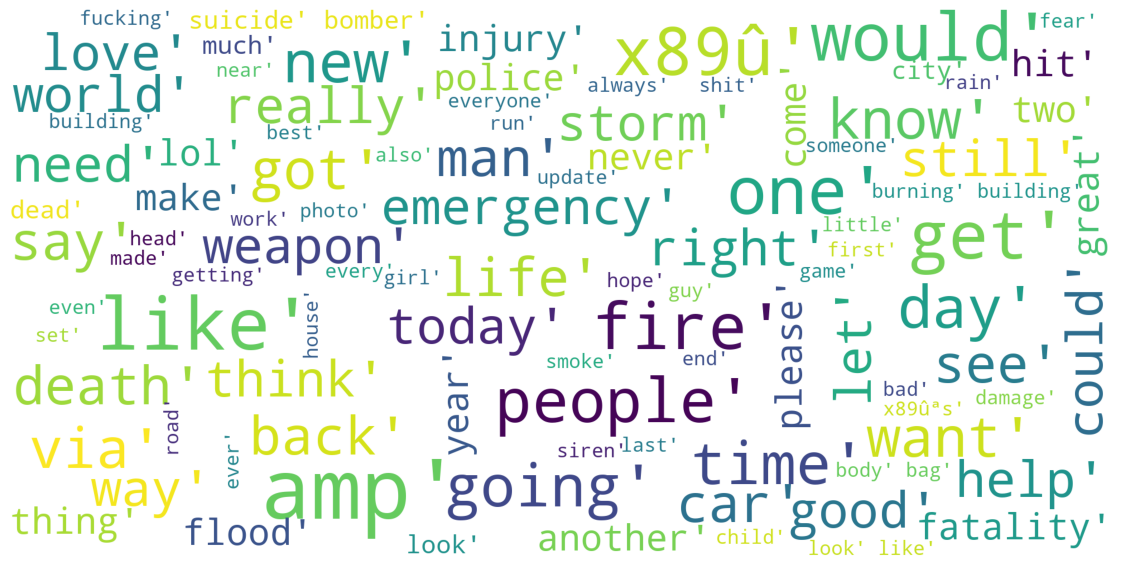

In [28]:
plot_wordcloud(train['text'])

In [29]:
# def _preprocess_text(text):
#         corpus=[]
#         lem=WordNetLemmatizer()
#         for news in text:
#             words=[w for w in word_tokenize(news) if (w not in stop)]
#             words=[lem.lemmatize(w) for w in words if len(w)>2]
#             corpus.append(words)
#         return corpus
    
# filtered = _preprocess_text(df['text'])

## Meta-Morphological Distribution
The meta features of data play important role in classification. In this section we will find use these feature to find out patterns in target classes and also compare test and train sets. 

In [30]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

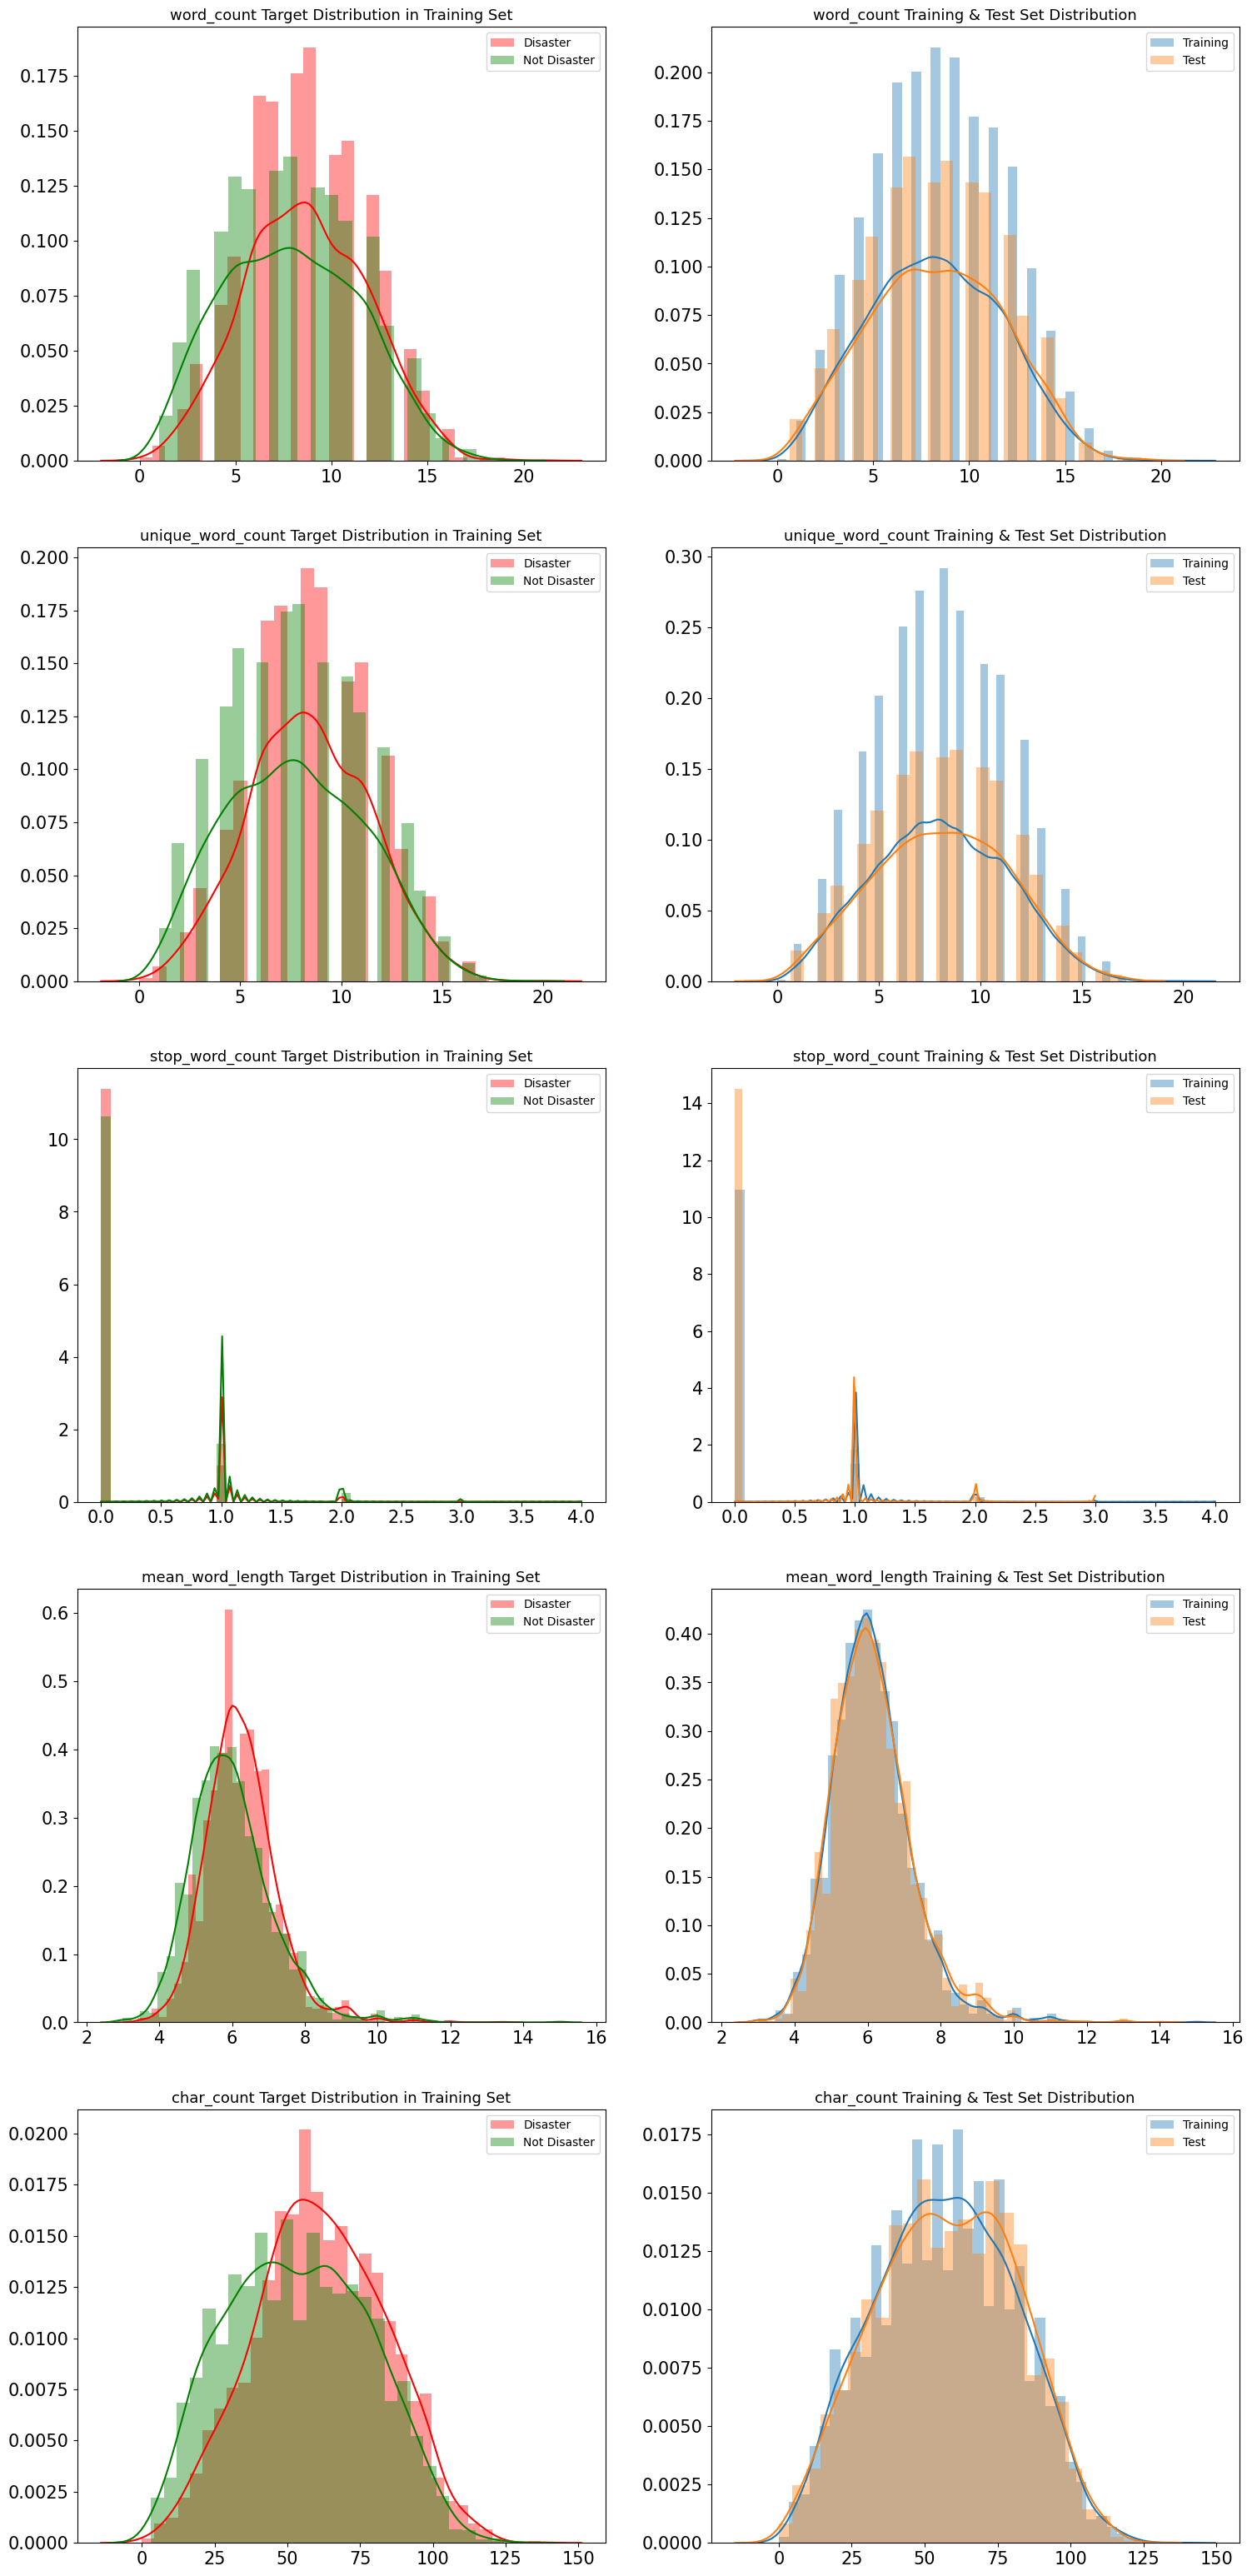

In [31]:
meta_data = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count']
DTwt = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(meta_data), figsize=(18,40), dpi=100)

for i, feature in enumerate(meta_data):
    
    sns.distplot(train.loc[DTwt][feature], label='Disaster', ax=axes[i][0], color='red')
    sns.distplot(train.loc[~DTwt][feature], label='Not Disaster', ax=axes[i][0], color='green')

    sns.distplot(train[feature], label='Training', ax=axes[i][1])
    sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=15)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [32]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [33]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
vocab_size = 10000
embedding_dim = 20
max_length = 600
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [35]:
trainset_tweets = []
trainset_labels = []

testset_tweets = []
testset_labels = []

for i in range(0, len(train)):
    # print(train['text'][i])
    trainset_tweets.append(train['text'][i])
    trainset_labels.append(train['target'][i])

for i in range(0, len(test)):
    # print(train['text'][i])
    testset_tweets.append(test['text'][i])
    testset_labels.append(test['target'][i])



In [36]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(trainset_tweets)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(trainset_tweets)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testset_tweets)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [37]:
training_padded = np.array(training_padded)
trainset_labels = np.array(trainset_labels)
testing_padded = np.array(testing_padded)
testset_labels = np.array(testset_labels)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 20)           200000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                504       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 200,529
Trainable params: 200,529
Non-trainable params: 0
_________________________________________________________________


In [40]:
num_epochs = 20
history = model.fit(training_padded, trainset_labels, epochs=num_epochs, validation_data=(testing_padded, testset_labels), verbose=2)

Epoch 1/20
238/238 - 1s - loss: 0.6844 - accuracy: 0.5703 - val_loss: 0.5567 - val_accuracy: 1.0000
Epoch 2/20
238/238 - 1s - loss: 0.6827 - accuracy: 0.5703 - val_loss: 0.5649 - val_accuracy: 1.0000
Epoch 3/20
238/238 - 1s - loss: 0.6817 - accuracy: 0.5703 - val_loss: 0.5706 - val_accuracy: 1.0000
Epoch 4/20
238/238 - 1s - loss: 0.6798 - accuracy: 0.5703 - val_loss: 0.5797 - val_accuracy: 1.0000
Epoch 5/20
238/238 - 1s - loss: 0.6767 - accuracy: 0.5703 - val_loss: 0.5923 - val_accuracy: 1.0000
Epoch 6/20
238/238 - 1s - loss: 0.6673 - accuracy: 0.5715 - val_loss: 0.4966 - val_accuracy: 1.0000
Epoch 7/20
238/238 - 1s - loss: 0.6427 - accuracy: 0.6204 - val_loss: 0.5492 - val_accuracy: 0.9087
Epoch 8/20
238/238 - 1s - loss: 0.5879 - accuracy: 0.7261 - val_loss: 0.5563 - val_accuracy: 0.8026
Epoch 9/20
238/238 - 1s - loss: 0.5195 - accuracy: 0.7956 - val_loss: 0.6060 - val_accuracy: 0.7404
Epoch 10/20
238/238 - 1s - loss: 0.4621 - accuracy: 0.8290 - val_loss: 0.6280 - val_accuracy: 0.7279

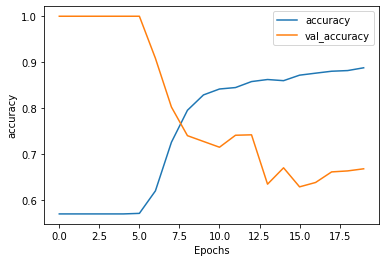

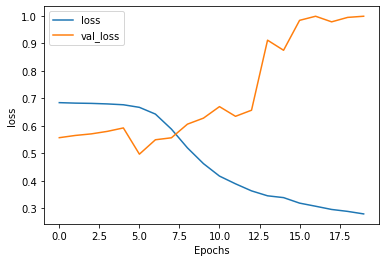

In [41]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [42]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(trainset_tweets[2])
print(trainset_labels[2])

deed reason may allah forgive ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 

In [43]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 20)


Example Sentences for Testing: 

---
1.   "The unprecedented rainfall in Karachi has disrupted life in the economic hub of Pakistan. My thoughts & prayers for the people of Karachi along with everyone who is in line of duty helping our brothers and sisters. May Allah protect you Karachi. My heart goes out to you." 

2.   What a breathtaking views of the beautiful Gabbin Jabba in Swat valley! Here you will find wild alpine meadows, evergreen woods, alpine lakes and soaring peaks.




In [44]:
sentence = [
            "The unprecedented rainfall in Karachi has disrupted life in the economic hub of Pakistan. My thoughts & prayers for the people of Karachi along with everyone who is in line of duty helping our brothers and sisters. May Allah protect you Karachi. My heart goes out to you.",
            "What a breathtaking views of the beautiful Gabbin Jabba in Swat valley! Here you will find wild alpine meadows, evergreen woods, alpine lakes and soaring peaks."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.940512  ]
 [0.18769681]]


Embeddings Projector: [link text](http://projector.tensorflow.org/?config=https://gist.githubusercontent.com/marvijokhio/9ae016b257b8a1c5dadb70d0e58ae282/raw/46f253c02d16d266849f311a8af61a3693e5356a/mjtensor_projection.json)

In [47]:
# import io

# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [48]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>